In [13]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import rotate, resize, pad, crop, hflip, vflip
import random
import matplotlib.pyplot as plt
from augmentations import *

For now, please do not run on any other dataset than dSprites!!!

In [29]:
BATCH_SIZE = 7

In [32]:
def convert_to_tripletBatch(batch):
    """"
    Translates Joseph Lee's honors thesis idea with data augmentation --> dataloader implementation 

    Proccesses a batch of data sequentially (in the form) of a list
    to return a batch of triplets (one image, its augmentation, and another image)
    or a (one image, its augmentation) pair 
    
    Keyword arguments:
    batch -- a list of images, its length is batch_size
    Return: Tensor with shape (batch_size, 3 or 2, num_channels, height, width)
    """

    # get image dimensions, assuming all images are the same size
    # and it is number-of-channels (nc) first
    nc, h, w = batch[0].shape[-3], batch[0].shape[-2], batch[0].shape[-1]
    batch_size = len(batch)

    """to return batches of 3 (original image, augmented original, and another image)
    implies we need at least two separate images to work off of""" 
    if batch_size >= 2:
        print(f"Batch size: {batch_size}")
        # format: (batch_size, 3 for (original, augmented, another), num_channels, height, width)
        # images_batch = torch.zeros((batch_size, 3, nc, h, w))
        images_batch = torch.zeros((batch_size * 3, nc, h, w))
        
        for i in range(batch_size - 1):         
            first_image_index = i
            second_image_index = i + 1 # can be i and i + 1 if we toggle shuffle = True, so that it's random
            first_image = batch[first_image_index]
            second_image = batch[second_image_index]
            first_image_augmented = random.choice(AUGMENTATIONS)(first_image)

            images_batch[3*i, :, :, :] = first_image
            images_batch[3*i+1, :, :, :] = first_image_augmented
            images_batch[3*i+2, :, :, :] = second_image

            # images_batch[i, 0, :, :, :] = first_image
            # images_batch[i, 1, :, :, :] = first_image_augmented
            # images_batch[i, 2, :, :, :] = second_image
        
        # the "second_image" here is the starting image of the batch
        # This is to address the out of bounds error
        last_idx = batch_size-1
        images_batch[3*last_idx, :, :, :] = batch[batch_size-1]
        images_batch[3*last_idx+1, :, :, :] = random.choice(AUGMENTATIONS)(batch[batch_size-1])
        images_batch[3*last_idx+2, :, :, :] = batch[0] 


    # otherwise, just create an (original image, augmented original) pair
    else:
        assert batch_size == 1
        # images_batch = torch.zeros((batch_size, 2, nc, h, w))
        images_batch = torch.zeros((batch_size * 2, nc, h, w))
        images_batch[0, :, :, :] = batch[0]
        images_batch[1, :, :, :] = random.choice(AUGMENTATIONS)(batch[batch_size-1])
        
    return images_batch
    # return images_batch.view((batch_size * 3, nc, h, w))


def convert_to_tripletBatch_debug(batch):
    """"
    Proccesses a PyTorch-default batch of data sequentially, which (in the form) of a list,
    to return a batch of triplets (one image, its augmentation, and another image)
    or a (one image, its augmentation) pair 
    
    Keyword arguments:
    batch -- a list of tensors representing images, its length is batch_size
    Return: Tensor with shape (batch_size, 3 or 2, num_channels, height, width)
    """

    print("Here is the batch in `collate_fn`")
    print(batch)
    print("List of Tensor sizes in batch:")
    print([tensor.shape for tensor in batch])

    return convert_to_tripletBatch(batch)

In [8]:
def show_triplets_in_batch(dataloader: DataLoader):
    import matplotlib.pyplot as plt

    fig, axs = plt.subplots(BATCH_SIZE, 3, figsize=(15, 15))

    batch = next(iter(dataloader))
    titles = ['Image 1', 'Augmented 1', 'Image 2']

    # for batch_idx, triplet in enumerate(batch):
    #     for triplet_idx, image in enumerate(triplet):
    #         axs[batch_idx, triplet_idx].imshow(torch.permute(image, (1, 2, 0)))
    #         axs[batch_idx, triplet_idx].set_title(titles[triplet_idx])

    for image_idx, image in enumerate(batch):
        batch_idx, triplet_idx = image_idx // 3, image_idx % 3
        axs[batch_idx, triplet_idx].imshow(torch.permute(image, (1,2,0)))
        axs[batch_idx, triplet_idx].set_title(titles[triplet_idx])
    
    
    fig.suptitle(f'Batch of {BATCH_SIZE} Triplets')

    plt.show()


In [39]:
class ImageDataset(Dataset):
    def __init__(self, images):
        self.images = images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        return self.images[index]

In [40]:
(1, *[3, 4])

(1, 3, 4)

# Toy Data Experimentation

In [41]:
# images = torch.randn(5, 1, 3, 3)
# dataset = ImageDataset(images)
# dataloader = DataLoader(dataset, batch_size=2, collate_fn=convert_to_tripletBatch_debug, shuffle=True)

# for batch in dataloader:
#     batch = batch.view(batch.shape[0]*batch.shape[1], *batch.shape[2:]) 
#     print(f"Batch output with shape {batch.shape}")
#     print(batch)
#     print("\n\n")

In [42]:
# images.shape

# CelebA

In [43]:
from torchvision.datasets import ImageFolder

class CustomImageFolder(ImageFolder):
    def __init__(self, root, transform=None):
        super(CustomImageFolder, self).__init__(root, transform)

    def __getitem__(self, index):
        path = self.imgs[index][0]
        img = self.loader(path)

        if self.transform is not None:
            img = self.transform(img)

        return img


In [44]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(), ])

train_kwargs = {'root': "./data/CelebA", 'transform': transform}
celeba_data = CustomImageFolder(**train_kwargs)

In [45]:
len(celeba_data)

202599

In [46]:
celeba_dataloader = DataLoader(celeba_data, batch_size=BATCH_SIZE, 
                               collate_fn=convert_to_tripletBatch, shuffle=True)

Batch size: 5


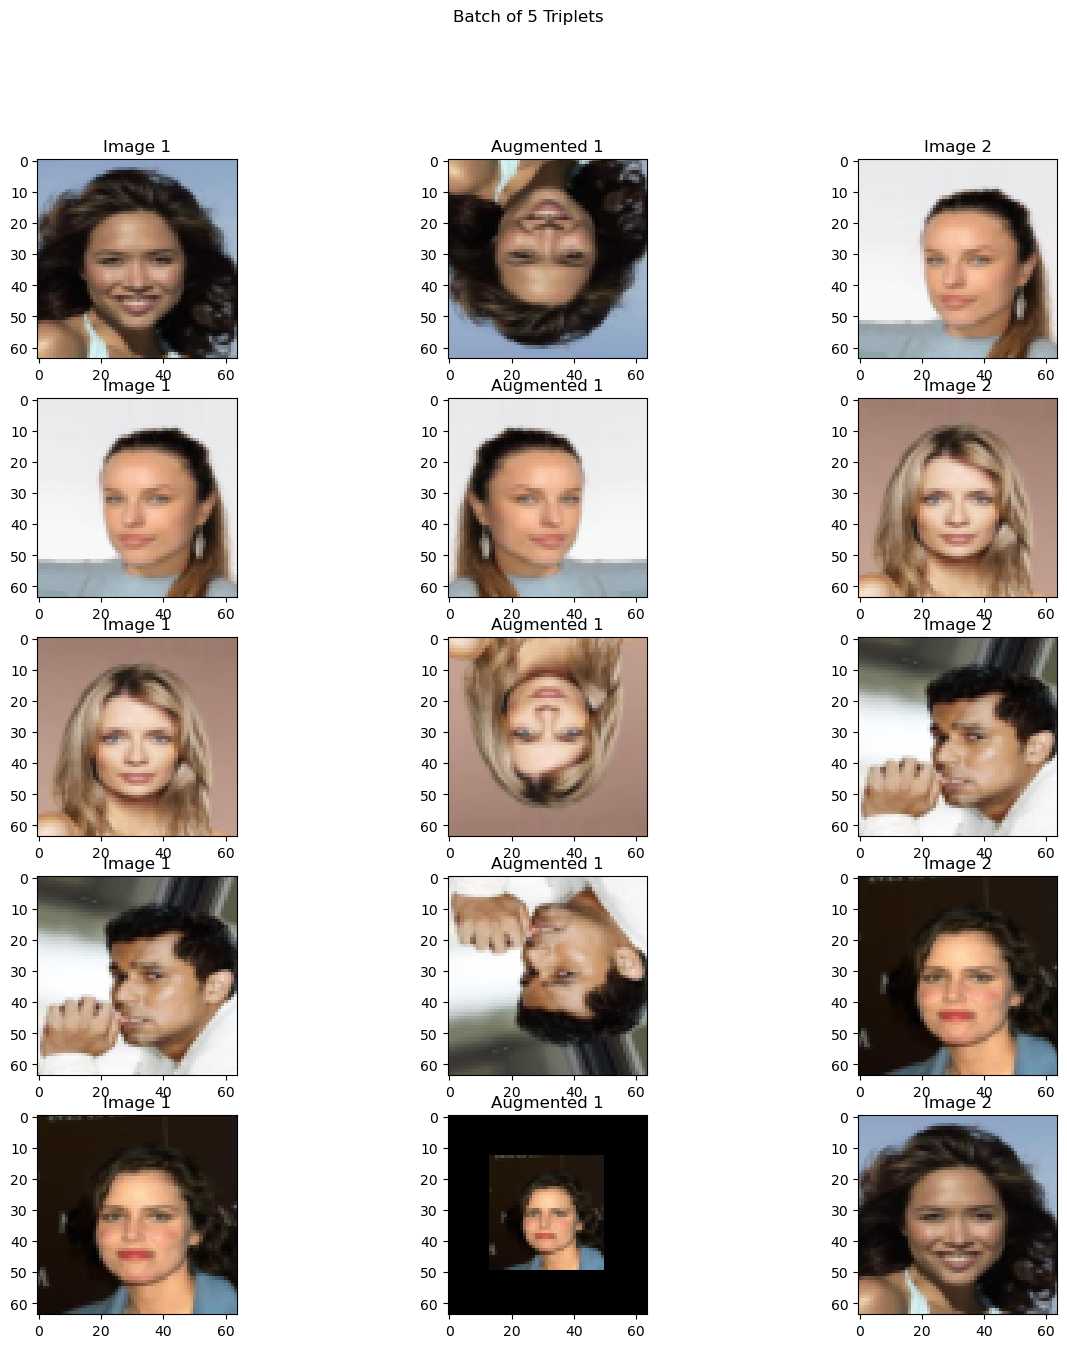

In [47]:
show_triplets_in_batch(celeba_dataloader)

# 3DChairs

In [48]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(), ])

train_kwargs = {'root': "./data/3DChairs", 'transform': transform}
chairs3D_data = CustomImageFolder(**train_kwargs)

In [49]:
chairs3D_dataloader = DataLoader(chairs3D_data, batch_size=BATCH_SIZE, 
                                 collate_fn=convert_to_tripletBatch, shuffle=True)

Batch size: 5


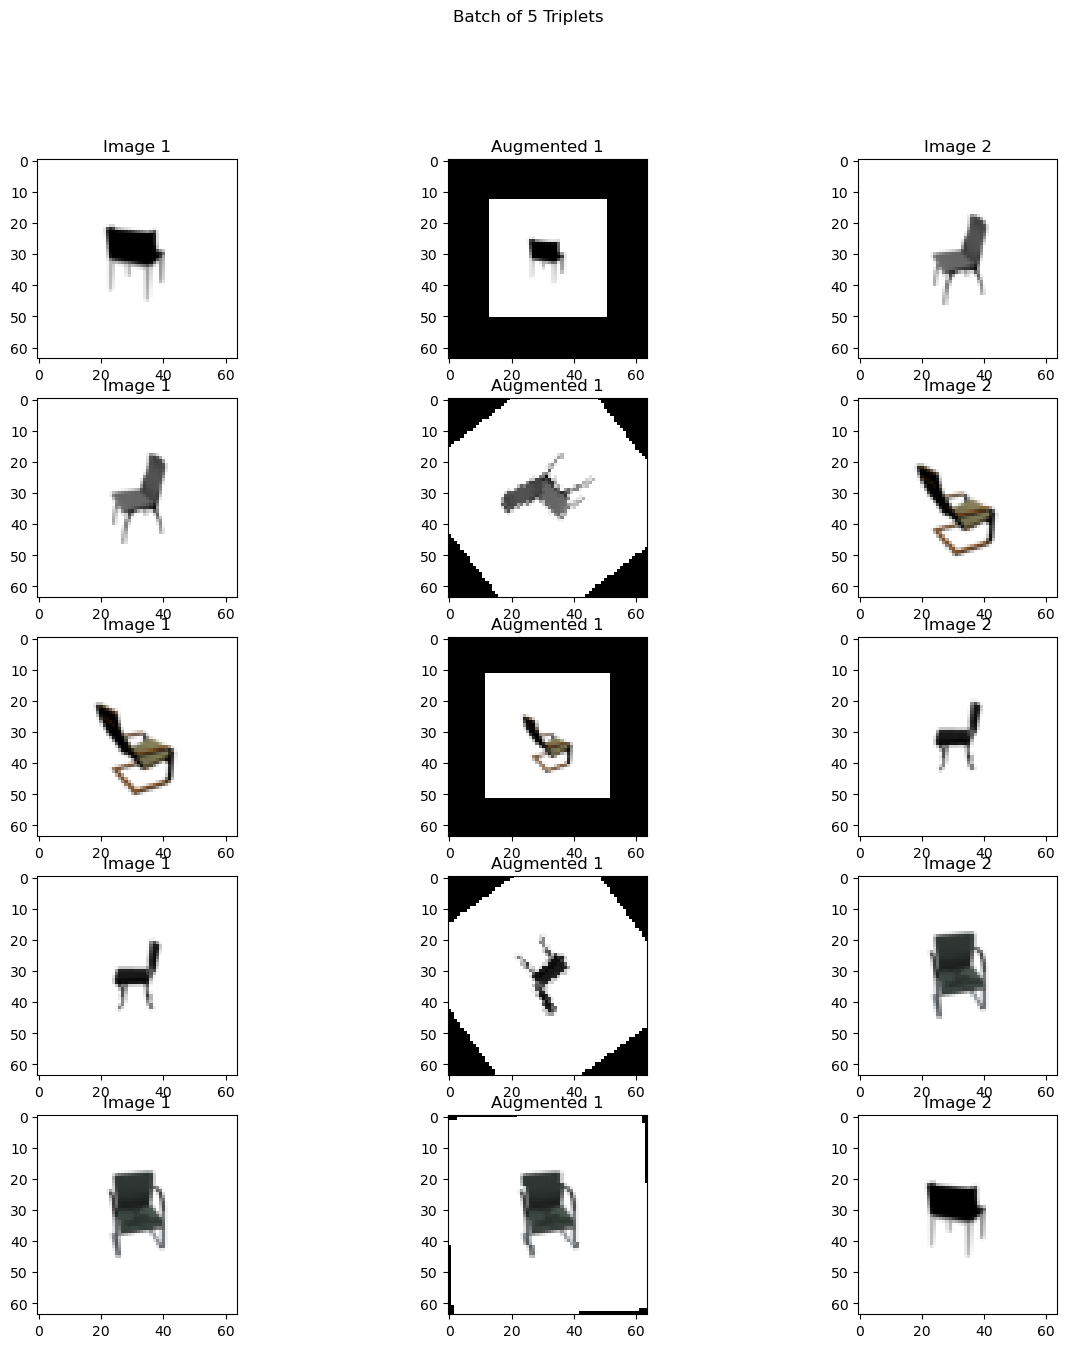

In [50]:
show_triplets_in_batch(chairs3D_dataloader)

# dSprites

In [9]:
class CustomTensorDataset(Dataset):
    def __init__(self, data_tensor):
        self.data_tensor = data_tensor

    def __getitem__(self, index):
        return self.data_tensor[index]

    def __len__(self):
        return self.data_tensor.size(0)


In [52]:
def triplet_batch_dSprites(batch):
    """"
    Translates Joseph Lee's honors thesis idea with data augmentation --> dataloader implementation 

    Proccesses a batch of data sequentially (in the form) of a list
    to return a batch of triplets (one image, its augmentation, and another image)
    or a (one image, its augmentation) pair 
    
    Keyword arguments:
    batch -- a list of images, its length is batch_size
    Return: Tensor with shape (batch_size, 3 or 2, num_channels, height, width)
    """

    # get image dimensions, assuming all images are the same size
    # and it is number-of-channels (nc) first
    nc, h, w = batch[0].shape[-3], batch[0].shape[-2], batch[0].shape[-1]
    batch_size = len(batch)

    """to return batches of 3 (original image, augmented original, and another image)
    implies we need at least two separate images to work off of""" 
    if batch_size >= 2:
        print(f"Batch size: {batch_size}")
        # format: (batch_size, 3 for (original, augmented, another), num_channels, height, width)
        images_batch = torch.zeros((batch_size, 3, nc, h, w))
        
        for i in range(batch_size - 1):         
            first_image_index = i
            second_image_index = i + 1 # can be i and i + 1 if we toggle shuffle = True, so that it's random
            first_image = batch[first_image_index]
            second_image = batch[second_image_index]
            first_image_augmented = random.choice(DSPRITE_AUGMENTATIONS)(first_image)

            images_batch[i, 0, :, :, :] = first_image
            images_batch[i, 1, :, :, :] = first_image_augmented
            images_batch[i, 2, :, :, :] = second_image
        
        # the "second_image" here is the starting image of the batch
        # This is to address the out of bounds error
        images_batch[batch_size-1, 0, :, :, :] = batch[batch_size-1]
        images_batch[batch_size-1, 1, :, :, :] = random.choice(DSPRITE_AUGMENTATIONS)(batch[batch_size-1])
        images_batch[batch_size-1, 2, :, :, :] = batch[0] 


    # otherwise, just create an (original image, augmented original) pair
    else:
        assert batch_size == 1
        images_batch = torch.zeros((batch_size, 2, nc, h, w))
        images_batch[0, 0, :, :, :] = batch[0]
        images_batch[0, 1, :, :, :] = random.choice(DSPRITE_AUGMENTATIONS)(batch[batch_size - 1]) 
        
    return images_batch.view((batch_size * 3, nc, h, w))



In [6]:
import numpy as np
dSprites_data = np.load("./data/dsprites-dataset/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz", encoding='bytes')
dSprites_data = torch.from_numpy(dSprites_data['imgs']).unsqueeze(1).float()

In [35]:
dSprites_dataset = CustomTensorDataset(data_tensor = dSprites_data)
dSprites_dataloader = DataLoader(dSprites_dataset, batch_size=BATCH_SIZE, 
                                 collate_fn=convert_to_tripletBatch, shuffle=True)

Batch size: 7


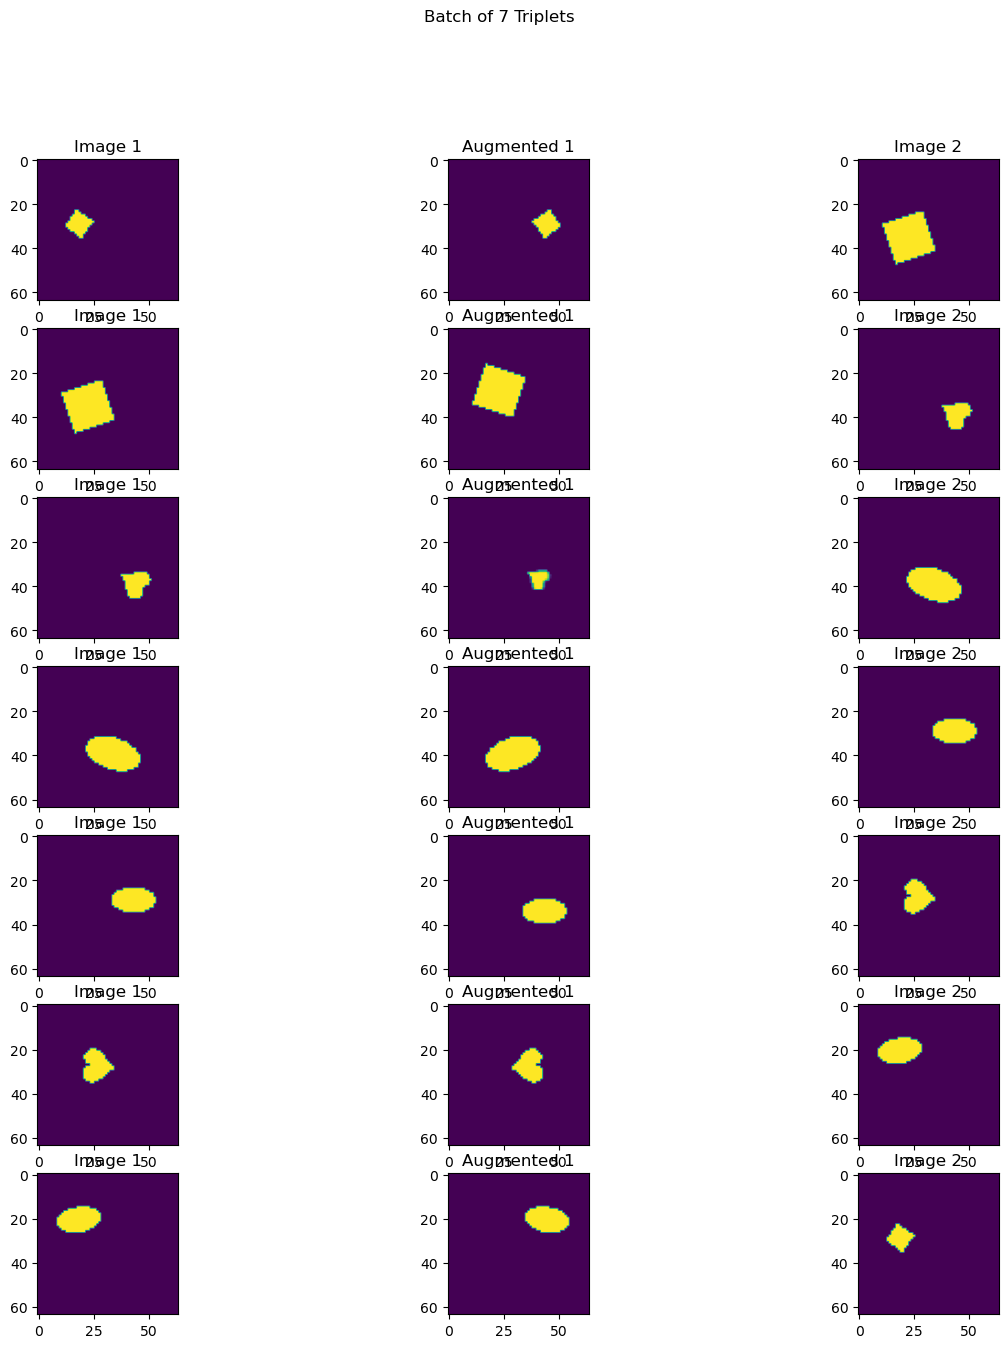

In [36]:
show_triplets_in_batch(dSprites_dataloader)

## Testing Out `dSprites` Augmentations at an Individual Sample Level

In [56]:
sample_ds_img = random.choice(dSprites_data)
# shape_locs_tup = sample_ds_img.nonzero(as_tuple=True)
# shape_locs_tup
shape_bounds = get_shape_bounds(sample_ds_img)
shape_bounds

(tensor(7), tensor(32), tensor(20), tensor(44))

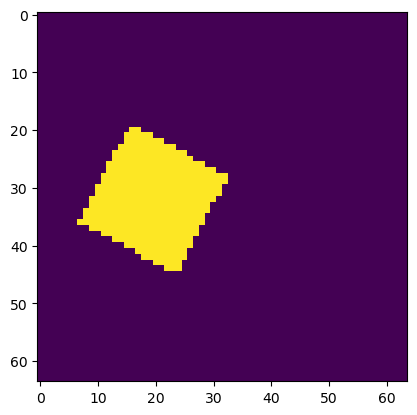

In [57]:
import matplotlib.pyplot as plt
plt.imshow(sample_ds_img.permute(1, 2, 0))

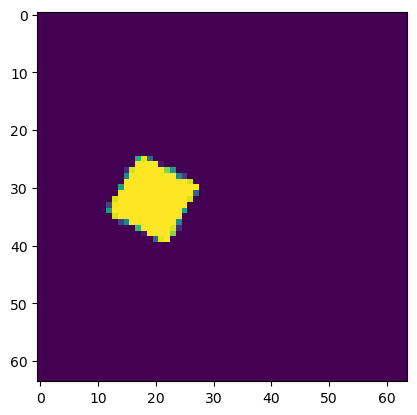

In [58]:
plt.imshow(shrink_shape_and_pad(sample_ds_img).permute(1, 2, 0))

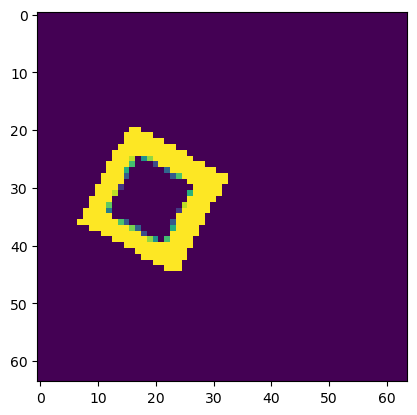

In [59]:
plt.imshow(sample_ds_img.permute(1,2,0) - shrink_shape_and_pad(sample_ds_img).permute(1, 2, 0))

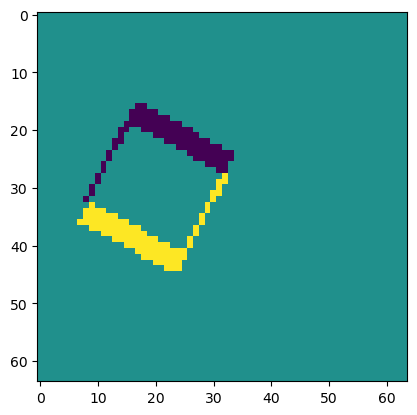

In [60]:
plt.imshow(sample_ds_img.permute(1,2,0) - translate_shape(sample_ds_img).permute(1, 2, 0))

# Sanity Checking

In [20]:
def triplet_batch_dSprites_sanity(batch):
    """"
    Translates Joseph Lee's honors thesis idea with data augmentation --> dataloader implementation 

    Proccesses a batch of data sequentially (in the form) of a list
    to return a batch of triplets (one image, its augmentation, and another image)
    or a (one image, its augmentation) pair 
    
    Keyword arguments:
    batch -- a list of images, its length is batch_size
    Return: Tensor with shape (batch_size, 3 or 2, num_channels, height, width)
    """

    # get image dimensions, assuming all images are the same size
    # and it is number-of-channels (nc) first
    nc, h, w = batch[0].shape[-3], batch[0].shape[-2], batch[0].shape[-1]
    batch_size = len(batch)

    """to return batches of 3 (original image, augmented original, and another image)
    implies we need at least two separate images to work off of""" 
    if batch_size >= 2:
        # format: (batch_size, 3 for (original, augmented, another), num_channels, height, width)
        # images_batch = torch.zeros((batch_size, 3, nc, h, w))
        images_batch = torch.zeros((batch_size * 3, nc, h, w))
        
        for i in range(batch_size - 1):         
            first_image_index = i
            second_image_index = i + 1 # can be i and i + 1 if we toggle shuffle = True, so that it's random
            first_image = batch[first_image_index]
            second_image = batch[second_image_index]
            # first_image_augmented = random.choice(DSPRITE_AUGMENTATIONS)(first_image)
            first_image_augmented = translate_shape(first_image)

            images_batch[3*i, :, :, :] = first_image
            images_batch[3*i+1, :, :, :] = first_image_augmented
            images_batch[3*i+2, :, :, :] = second_image

            # images_batch[i, 0, :, :, :] = first_image
            # images_batch[i, 1, :, :, :] = first_image_augmented
            # images_batch[i, 2, :, :, :] = second_image
        
        # the "second_image" here is the starting image of the batch
        # This is to address the out of bounds error
        last_idx = batch_size-1
        images_batch[3*last_idx, :, :, :] = batch[batch_size-1]
        # images_batch[3*last_idx+1, :, :, :] = random.choice(DSPRITE_AUGMENTATIONS)(batch[batch_size-1])
        images_batch[3*last_idx+1, :, :, :] = translate_shape(batch[batch_size-1])
        images_batch[3*last_idx+2, :, :, :] = batch[0] 


    # otherwise, just create an (original image, augmented original) pair
    else:
        assert batch_size == 1
        # images_batch = torch.zeros((batch_size, 2, nc, h, w))
        images_batch = torch.zeros((batch_size * 2, nc, h, w))
        images_batch[0, :, :, :] = batch[0]
        # images_batch[1, :, :, :] = random.choice(DSPRITE_AUGMENTATIONS)(batch[batch_size-1])
        images_batch[1, :, :, :] = translate_shape(batch[batch_size-1])
        
        
    return images_batch
    # return images_batch.view((batch_size * 3, nc, h, w))
